# Machine Intelligence II - Team MensaNord
## Sheet 11

- Nikolai Zaki
- Alexander Moore
- Johannes Rieke
- Georg Hoelger
- Oliver Atanaszov

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import numpy as np
import math
from scipy.ndimage import imread

### Exercise 1

In [2]:
img_orig = imread('testimg.jpg').flatten()
print("shape: ", img_orig.shape)
print("values: from ", img_orig.min(), " to ", img_orig.max())

img = np.zeros((3,img_orig.shape[0]))
print(img.shape)

std = [0, 0.05, 0.1]
for i in range(img.shape[1]):
    # normalize => img[0]
    img[0][i] = img_orig[i] / 255
    # gaussian noise => img[1] img[2]
    img[1][i] = img[0][i] + np.random.normal(0, std[1])
    img[2][i] = img[0][i] + np.random.normal(0, std[2])
    
print(img[:, 0:3])

shape:  (177500,)
values: from  0  to  255
(3, 177500)
[[ 0.63529412  0.63137255  0.62745098]
 [ 0.59073825  0.59434021  0.59168809]
 [ 0.67399138  0.62474877  0.65619793]]


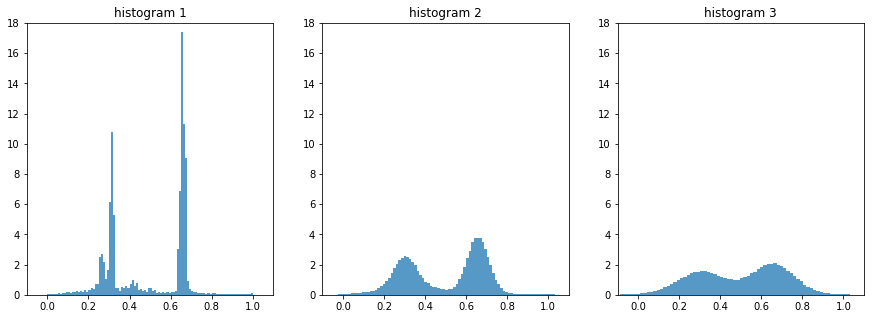

In [3]:
# histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.hist(img[i], 100, normed=1, alpha=0.75)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 18)
    plt.title('histogram {}'.format(i+1))

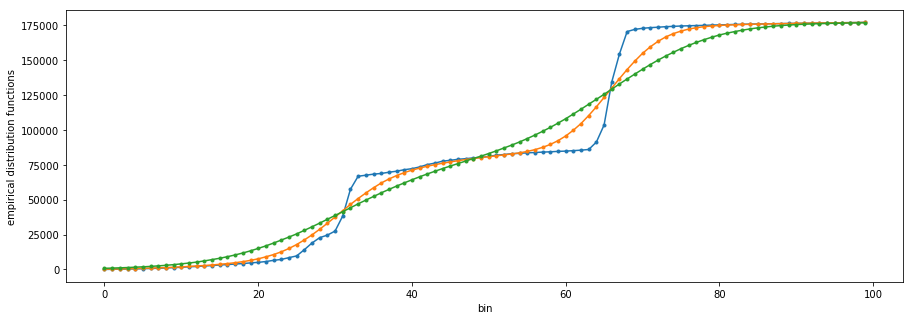

In [4]:
nbins = 100
bins = np.linspace(0, 1, nbins+1)

elementsPerBin = np.zeros((3,nbins))
for i in range(3):
    ind = np.digitize(img[i], bins)
    # print("minmax: ", ind.min(), ind.max())
    elementsPerBin[i] = [len(img[i][ind == j]) for j in range(nbins)]
    if nbins <= 20:
        print(elementsPerBin[i], "\n")        
        
sumUptoBinX = np.asarray([[0 for i in range(nbins)] for i in range(3)])
for i in range(3):
    for j in range(nbins):
        sumUptoBinX[i][j] = np.sum(elementsPerBin[i][0:j+1])
    if nbins <= 20:
        print(sumUptoBinX[i], "\n")
        
#TODO? /= bin width    
    
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.plot(sumUptoBinX[i], '.-')
plt.xlabel('bin')
plt.ylabel('empirical distribution functions');

In [5]:
def H(vec, h):
    """
    Histogram kernel function
    """
    vec = np.asarray(vec)
    return np.asarray([1 if abs(x)<.5 else 0 for x in vec])

In [6]:
def P_est(x, h, data, kernel = H):
    n = 1 #= data.shape[1] #number of dimensions (for multidmensional data)
    p = len(data)
    return 1/(h**n)/p*np.sum(kernel((data - x)/h, h))

In [7]:
P = 100
h = .15
nCenters = 101
Centers = np.linspace(0,1,nCenters)
offset = int(1e5)
data = np.zeros((10,P))
for i in range(10):
    data[i] = img[0][offset+i*P:offset+(i+1)*P]

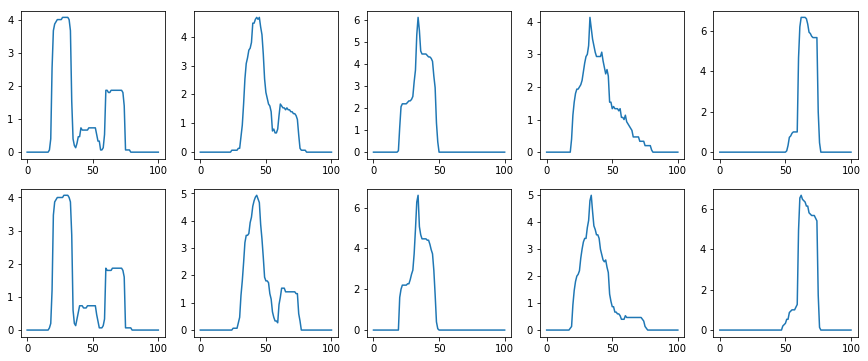

In [8]:
fig, ax = plt.subplots(2,5,figsize=(15,6))
ax = ax.ravel()
for i in range(10):
    ax[i].plot([P_est(center,h,data[i]) for center in Centers])

In [9]:
testdata = img[0][int(offset/2):int(offset/2+5000)]

def avg_NegLL(data, h, testdata=testdata, kernel=H):
    summe =0
    for i in range(10):
        L_prob = [np.log(P_est(x,h,data[i],kernel)) for x in testdata]
        negLL = -1*np.sum(L_prob)
#         print(negLL)
        summe += negLL
    summe /= 10
    return summe
# avg_NegLL(data,h,testdata)

In [10]:
def this_procedure(data, testdata=testdata, kernel=H):
    hs = np.linspace(0.01, 0.5, 20)
    LLs = [avg_NegLL(data,h,testdata, kernel) for h in hs]
    plt.plot(hs,LLs)

/home/dpenguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


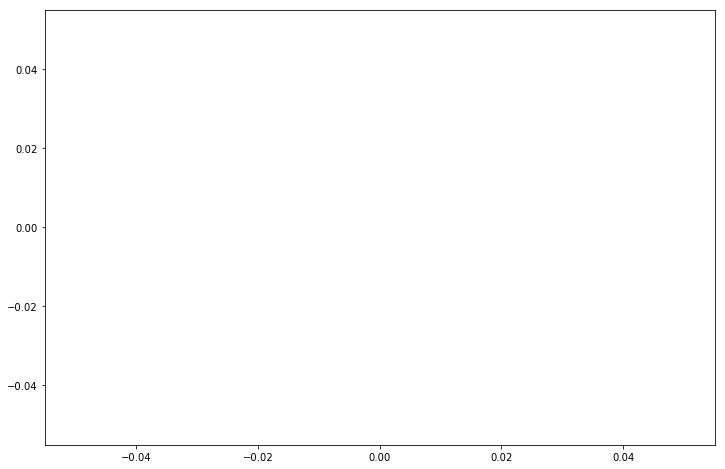

In [11]:
data = np.zeros((10,P))
fig = plt.figure(figsize=(12,8))
for j in range(3):
    for i in range(10):
        data[i] = img[j][offset+i*P:offset+(i+1)*P]
    this_procedure(data)
plt.show()   

/home/dpenguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


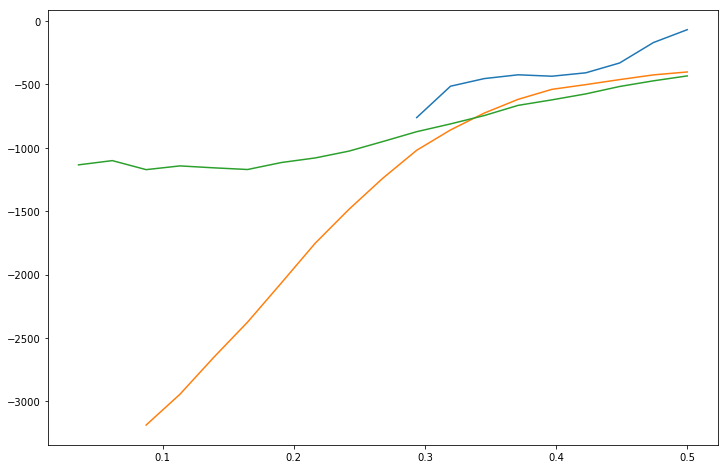

In [12]:
P = 500
data = np.zeros((10,P))
fig = plt.figure(figsize=(12,8))
for j in range(3):
    for i in range(10):
        data[i] = img[j][offset+i*P:offset+(i+1)*P]
    this_procedure(data)
plt.show() 

In [13]:
def Gaussian(x,h):
    return np.exp(-x**2/h/2)/np.sqrt(2*np.pi*h)

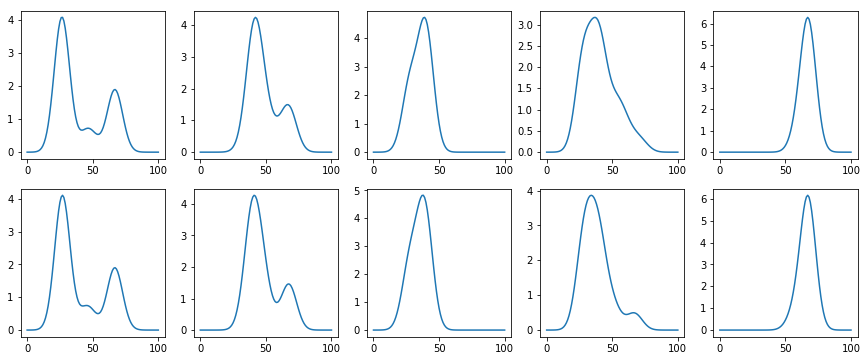

In [14]:
fig, ax = plt.subplots(2,5,figsize=(15,6))
h = .15
P = 100
data = np.zeros((10,P))
for i in range(10):
    data[i] = img[0][offset+i*P:offset+(i+1)*P]
ax = ax.ravel()
for i in range(10):
    ax[i].plot([P_est(center,h,data[i],kernel=Gaussian) for center in Centers])

/home/dpenguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


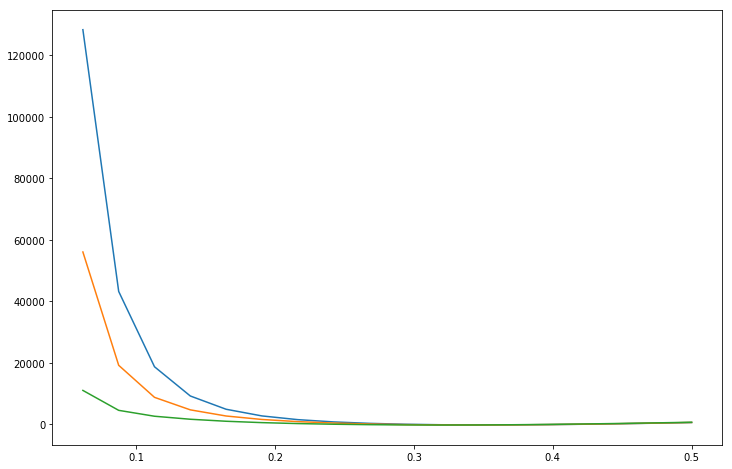

In [15]:
data = np.zeros((10,P))
fig = plt.figure(figsize=(12,8))
for j in range(3):
    for i in range(10):
        data[i] = img[j][offset+i*P:offset+(i+1)*P]
    this_procedure(data,kernel=Gaussian)
plt.show() 

/home/dpenguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


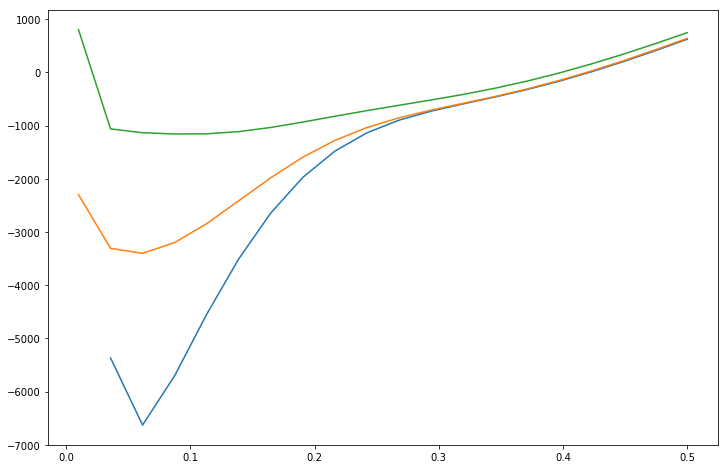

In [16]:
P = 500
data = np.zeros((10,P))
fig = plt.figure(figsize=(12,8))
for j in range(3):
    for i in range(10):
        data[i] = img[j][offset+i*P:offset+(i+1)*P]
    this_procedure(data,kernel=Gaussian)
plt.show() 